# Домашнее задание к семинару 07 (HW07)
Тема: кластеризация, внутренние метрики качества, PCA/t-SNE и "честный" unsupervised-эксперимент на синтетических данных.

In [69]:
# Если вы запускаете ноутбук в "чистом" окружении:
# pip install -U scikit-learn matplotlib numpy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
# np.random.seed(RANDOM_STATE)


In [ ]:
# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [0.3, 0.5, 0.8, 1.0, 1.2, 1.5, 2.0, 2.5, 3.0]
dbscan_min_samples = [3, 5, 10, 15, 20]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

print("Config:")
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)
print(" agg ks:", (agg_ks[0], "...", agg_ks[-1]))
print(" agg linkages:", agg_linkages)


Config:
 pca_dim: 30
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]
 agg ks: (2, '...', 20)
 agg linkages: ['ward', 'complete', 'average']


## Загрузка данных и первичный анализ (для каждого датасета)


### S07-hw-dataset-01.csv

In [45]:
# 1. Загрузка
df1 = pd.read_csv('data/S07-hw-dataset-01.csv')

In [46]:
df1.head()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
0,0,-0.536647,-69.812900,-0.002657,71.743147,-11.396498,-12.291287,-6.836847,-0.504094
1,1,15.230731,52.727216,-1.273634,-104.123302,11.589643,34.316967,-49.468873,0.390356
2,2,18.542693,77.317150,-1.321686,-111.946636,10.254346,25.892951,44.595250,0.325893
3,3,-12.538905,-41.709458,0.146474,16.322124,1.391137,2.014316,-39.930582,0.139297
4,4,-6.903056,61.833444,-0.022466,-42.631335,3.107154,-5.471054,7.001149,0.131213


In [47]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 non-null  float64
 4   f04        12000 non-null  float64
 5   f05        12000 non-null  float64
 6   f06        12000 non-null  float64
 7   f07        12000 non-null  float64
 8   f08        12000 non-null  float64
dtypes: float64(8), int64(1)
memory usage: 843.9 KB


In [48]:
df1.describe()

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [49]:
print("Количество пропусков по столбцам:")
df1.isnull().sum()

Количество пропусков по столбцам:


sample_id    0
f01          0
f02          0
f03          0
f04          0
f05          0
f06          0
f07          0
f08          0
dtype: int64

In [50]:
print("\nДоли пропусков:")
df1.isnull().mean()


Доли пропусков:


sample_id    0.0
f01          0.0
f02          0.0
f03          0.0
f04          0.0
f05          0.0
f06          0.0
f07          0.0
f08          0.0
dtype: float64

In [51]:
df1.dtypes

sample_id      int64
f01          float64
f02          float64
f03          float64
f04          float64
f05          float64
f06          float64
f07          float64
f08          float64
dtype: object

In [52]:
# Определение X и sample_id
sample_id1 = df1['sample_id']
X1 = df1.drop(columns=['sample_id'])
print(f"Размер X1: {X1.shape}")

Размер X1: (12000, 8)


### S07-hw-dataset-02.csv

In [53]:
# 1. Загрузка
df2 = pd.read_csv('data/S07-hw-dataset-02.csv')

In [54]:
df2.head()

,sample_id,x1,x2,z_noise
0,0,0.098849,-1.846034,21.288122
1,1,-1.024516,1.829616,6.072952
2,2,-1.094178,-0.158545,-18.938342
3,3,-1.612808,-1.565844,-11.629462
4,4,1.659901,-2.133292,1.895472


In [55]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB


In [56]:
df2.describe()

,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [57]:
print("Количество пропусков по столбцам:")
df2.isnull().sum()

Количество пропусков по столбцам:


sample_id    0
x1           0
x2           0
z_noise      0
dtype: int64

In [58]:
print("\nДоли пропусков:")
df2.isnull().mean()


Доли пропусков:


sample_id    0.0
x1           0.0
x2           0.0
z_noise      0.0
dtype: float64

In [59]:
df2.dtypes

sample_id      int64
x1           float64
x2           float64
z_noise      float64
dtype: object

In [60]:
# Определение X и sample_id
sample_id2 = df2['sample_id']
X2 = df2.drop(columns=['sample_id'])
print(f"Размер X2: {X2.shape}")

Размер X2: (8000, 3)


### S07-hw-dataset-03.csv

In [61]:
# 1. Загрузка
df3 = pd.read_csv('data/S07-hw-dataset-03.csv')

In [62]:
df3.head()

,sample_id,x1,x2,f_corr,f_noise
0,0,-2.710470,4.997107,-1.015703,0.718508
1,1,8.730238,-8.787416,3.953063,-1.105349
2,2,-1.079600,-2.558708,0.976628,-3.605776
3,3,6.854042,1.560181,1.760614,-1.230946
4,4,9.963812,-8.869921,2.966583,0.915899


In [63]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB


In [64]:
df3.describe()

,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [65]:
print("Количество пропусков по столбцам:")
df3.isnull().sum()

Количество пропусков по столбцам:


sample_id    0
x1           0
x2           0
f_corr       0
f_noise      0
dtype: int64

In [66]:
print("\nДоли пропусков:")
df3.isnull().mean()


Доли пропусков:


sample_id    0.0
x1           0.0
x2           0.0
f_corr       0.0
f_noise      0.0
dtype: float64

In [67]:
df3.dtypes

sample_id      int64
x1           float64
x2           float64
f_corr       float64
f_noise      float64
dtype: object

In [68]:
# Определение X и sample_id
sample_id3 = df3['sample_id']
X3 = df3.drop(columns=['sample_id'])
print(f"Размер X3: {X3.shape}")

Размер X3: (15000, 4)


## Препроцессинг


In [73]:
preprocessor = Pipeline([
    ('scaler', StandardScaler())
])

# Применяем препроцессинг к каждому датасету
X1_scaled = preprocessor.fit_transform(X1)
X2_scaled = preprocessor.fit_transform(X2)
X3_scaled = preprocessor.fit_transform(X3)

print(X1_scaled.shape)
print(X2_scaled.shape)
print(X3_scaled.shape)

print("\nМасштабированные данные (первые 3 строки):")
print(X1_scaled[:3])
print("\nСредние после масштабирования:")
print(f"Столбец 0: {X1_scaled[:, 0].mean():.6f}")
print(f"Столбец 1: {X1_scaled[:, 1].mean():.6f}")
print("\nСтандартные отклонения после масштабирования:")
print(f"Столбец 0: {X1_scaled[:, 0].std():.6f}")
print(f"Столбец 1: {X1_scaled[:, 1].std():.6f}")

(12000, 8)
(8000, 3)
(15000, 4)

Масштабированные данные (первые 3 строки):
[[ 0.17142668 -1.46280499  0.43827875  1.35028177 -1.5948697  -0.89591542
  -0.11539556 -0.84301268]
 [ 1.60302144  0.55306178 -2.1005838  -1.61705848  1.67664705  2.2545476
  -0.83142723  0.6304788 ]
 [ 1.90373017  0.95758263 -2.19656934 -1.74905918  1.48660018  1.68513022
   0.74843886  0.52428406]]

Средние после масштабирования:
Столбец 0: 0.000000
Столбец 1: -0.000000

Стандартные отклонения после масштабирования:
Столбец 0: 1.000000
Столбец 1: 1.000000


## Модели недели 7 (для каждого датасета – минимум 2 алгоритма)


In [154]:
def safe_cluster_metrics(X, labels):
    """Считает метрики; возвращает None, если метрика неприменима."""
    unique = np.unique(labels)
    # Нужно минимум 2 кластера
    if len(unique) < 2:
        return None

    # Нельзя, чтобы все точки были в одном кластере
    if len(unique) == 1:
        return None

    # silhouette требует, чтобы все кластеры имели >1 точки (часто, но не всегда)
    # В sklearn silhouette_score может падать, если какой-то кластер пуст/особый.
    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    """PCA(2D) именно для визуализации."""
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title, short_title):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)

    plt.savefig(f'artifacts/figures/{short_title}', dpi=300, bbox_inches='tight')
    plt.show()

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))


### KMeans (подбор k)


In [135]:
RANDOM_STATE = 80

In [137]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

In [132]:
kmeans_results1 = eval_kmeans_grid(X1_scaled, kmeans_ks)
print(len(kmeans_results1), kmeans_results1[0]["params"], kmeans_results1[-1]["params"])

kmeans_results2 = eval_kmeans_grid(X2_scaled, kmeans_ks)
print(len(kmeans_results2), kmeans_results2[0]["params"], kmeans_results2[-1]["params"])

kmeans_results3 = eval_kmeans_grid(X3_scaled, kmeans_ks)
print(len(kmeans_results3), kmeans_results3[0]["params"], kmeans_results3[-1]["params"])


19 {'k': 2} {'k': 20}
19 {'k': 2} {'k': 20}
19 {'k': 2} {'k': 20}


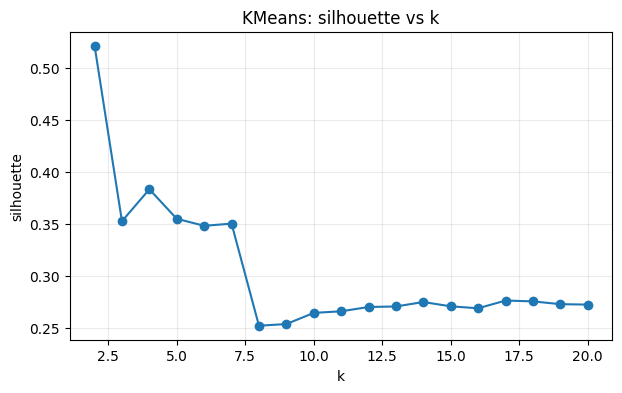

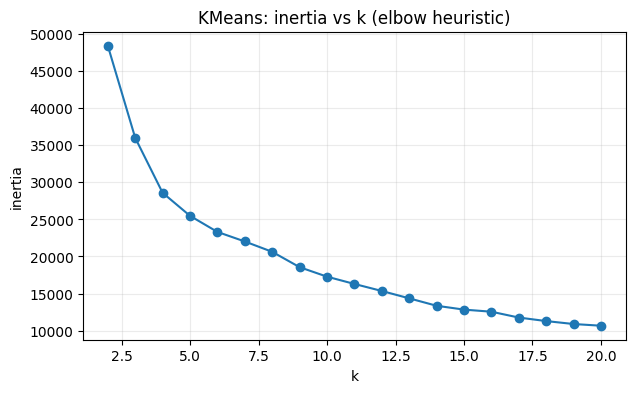

In [ ]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results1]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results1]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k 1', dpi=300, bbox_inches='tight')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results1]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k (elbow) 1', dpi=300, bbox_inches='tight')
plt.show()


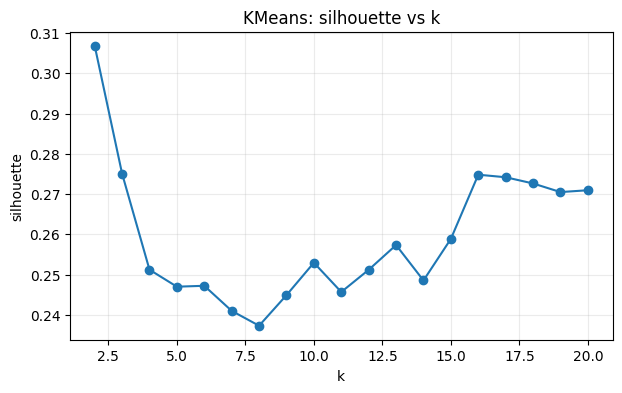

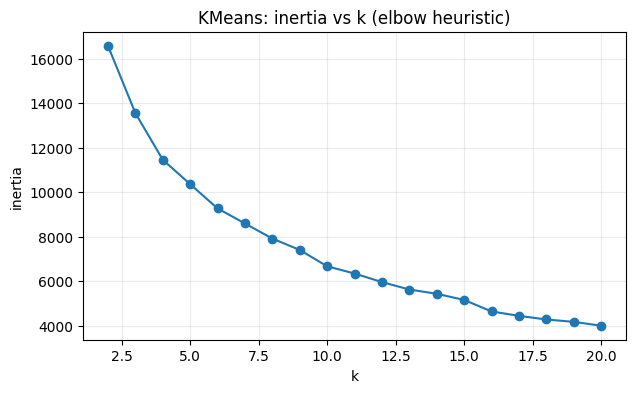

In [147]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results2]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results2]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k 2', dpi=300, bbox_inches='tight')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results2]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k (elbow) 2', dpi=300, bbox_inches='tight')
plt.show()


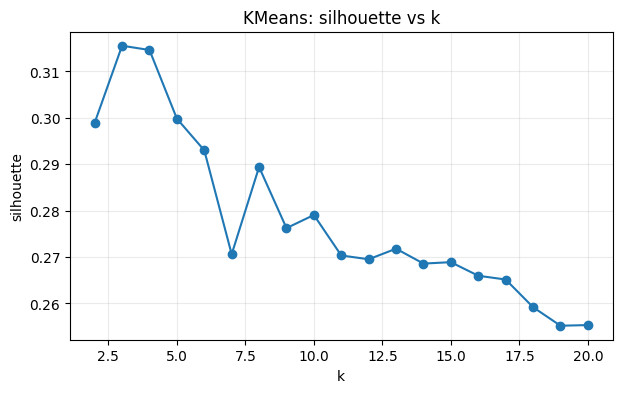

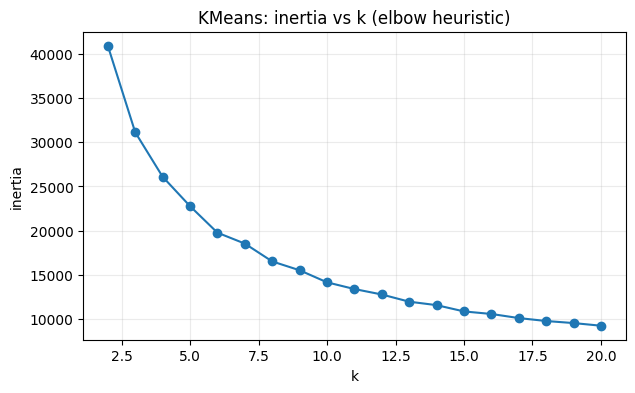

In [148]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results3]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results3]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k 3', dpi=300, bbox_inches='tight')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results3]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)

plt.savefig('artifacts/figures/silhouette VS k (elbow) 3', dpi=300, bbox_inches='tight')
plt.show()


Выберем “лучший” вариант по silhouette (это не единственный критерий, но для демо – удобно).


In [133]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

best_kmeans1, best_kmeans_s1 = pick_best_by_silhouette(kmeans_results1)
print(best_kmeans1["params"], round(best_kmeans_s1, 3))

best_kmeans2, best_kmeans_s2 = pick_best_by_silhouette(kmeans_results2)
print(best_kmeans2["params"], round(best_kmeans_s2, 3))

best_kmeans3, best_kmeans_s3 = pick_best_by_silhouette(kmeans_results3)
print(best_kmeans3["params"], round(best_kmeans_s3, 3))

{'k': 2} 0.522
{'k': 2} 0.307
{'k': 3} 0.316


### DBSCAN (eps, min_samples)

In [95]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

In [96]:
dbscan_results1 = eval_dbscan_grid(X1_scaled, dbscan_eps, dbscan_min_samples)
print(len(dbscan_results1))

dbscan_results2 = eval_dbscan_grid(X2_scaled, dbscan_eps, dbscan_min_samples)
print(len(dbscan_results2))

dbscan_results3 = eval_dbscan_grid(X3_scaled, dbscan_eps, dbscan_min_samples)
print(len(dbscan_results3))

45
45
45


In [97]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results1 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted1 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted1[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 40
{'eps': 2.0, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 15} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 20} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2


In [98]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results2 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted2 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted2[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 10
{'eps': 0.8, 'min_samples': 15} sil= 0.545 noise= 0.038 clusters= 2
{'eps': 1.0, 'min_samples': 20} sil= 0.457 noise= 0.011 clusters= 2
{'eps': 0.8, 'min_samples': 10} sil= 0.414 noise= 0.012 clusters= 2
{'eps': 0.8, 'min_samples': 20} sil= 0.26 noise= 0.045 clusters= 3
{'eps': 0.3, 'min_samples': 20} sil= 0.258 noise= 0.115 clusters= 2
{'eps': 0.5, 'min_samples': 10} sil= 0.251 noise= 0.064 clusters= 2
{'eps': 0.3, 'min_samples': 5} sil= 0.085 noise= 0.072 clusters= 5
{'eps': 0.5, 'min_samples': 5} sil= -0.058 noise= 0.045 clusters= 14


In [99]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results3 if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted3 = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted3[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 11
{'eps': 0.8, 'min_samples': 3} sil= 0.373 noise= 0.001 clusters= 2
{'eps': 0.3, 'min_samples': 20} sil= 0.359 noise= 0.377 clusters= 6
{'eps': 0.3, 'min_samples': 15} sil= 0.269 noise= 0.299 clusters= 7
{'eps': 0.5, 'min_samples': 20} sil= 0.184 noise= 0.049 clusters= 3
{'eps': 0.5, 'min_samples': 15} sil= 0.144 noise= 0.04 clusters= 2
{'eps': 0.5, 'min_samples': 10} sil= 0.142 noise= 0.032 clusters= 2
{'eps': 0.3, 'min_samples': 10} sil= 0.038 noise= 0.216 clusters= 8
{'eps': 0.5, 'min_samples': 5} sil= -0.104 noise= 0.022 clusters= 4


In [100]:
# 1. Проверим, сколько кластеров и шума получает DBSCAN на датасетах 2 и 3
print("=== DBSCAN диагностика ===")

for i, (X, results) in enumerate([(X2_scaled, dbscan_results2), (X3_scaled, dbscan_results3)], 2):
    print(f"\nДатасет {i}:")
    for r in results:
        labels = r["labels"]
        unique, counts = np.unique(labels, return_counts=True)
        n_clusters = len(unique) - (1 if -1 in unique else 0)
        noise_points = counts[unique == -1][0] if -1 in unique else 0
        noise_frac = noise_points / len(labels)
        
        print(f"  eps={r['params']['eps']:.1f}, min_samples={r['params']['min_samples']}: "
              f"кластеров={n_clusters}, шум={noise_frac:.1%}")

=== DBSCAN диагностика ===

Датасет 2:
  eps=0.3, min_samples=3: кластеров=30, шум=5.9%
  eps=0.3, min_samples=5: кластеров=5, шум=7.2%
  eps=0.3, min_samples=10: кластеров=1, шум=8.6%
  eps=0.3, min_samples=15: кластеров=1, шум=9.8%
  eps=0.3, min_samples=20: кластеров=2, шум=11.5%
  eps=0.5, min_samples=3: кластеров=32, шум=2.5%
  eps=0.5, min_samples=5: кластеров=14, шум=4.5%
  eps=0.5, min_samples=10: кластеров=2, шум=6.4%
  eps=0.5, min_samples=15: кластеров=1, шум=6.7%
  eps=0.5, min_samples=20: кластеров=1, шум=6.8%
  eps=0.8, min_samples=3: кластеров=1, шум=0.4%
  eps=0.8, min_samples=5: кластеров=1, шум=0.5%
  eps=0.8, min_samples=10: кластеров=2, шум=1.2%
  eps=0.8, min_samples=15: кластеров=2, шум=3.8%
  eps=0.8, min_samples=20: кластеров=3, шум=4.5%
  eps=1.0, min_samples=3: кластеров=1, шум=0.2%
  eps=1.0, min_samples=5: кластеров=1, шум=0.2%
  eps=1.0, min_samples=10: кластеров=1, шум=0.3%
  eps=1.0, min_samples=15: кластеров=1, шум=0.6%
  eps=1.0, min_samples=20: кластер

In [101]:
best_dbscan1 = valid_sorted1[0] if valid_sorted1 else None
print(best_dbscan1["params"] if best_dbscan1 else "No valid config found")

best_dbscan2 = valid_sorted2[0] if valid_sorted2 else None
print(best_dbscan2["params"] if best_dbscan2 else "No valid config found")

best_dbscan3 = valid_sorted3[0] if valid_sorted3 else None
print(best_dbscan3["params"] if best_dbscan3 else "No valid config found")

{'eps': 2.0, 'min_samples': 3}
{'eps': 0.8, 'min_samples': 15}
{'eps': 0.8, 'min_samples': 3}


### Agglomerative (k, linkage)


In [103]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

In [104]:
agg_results1 = eval_agglomerative_grid(X1_scaled, agg_ks, agg_linkages)
print(len(agg_results1), agg_results1[0]["params"])

agg_results2 = eval_agglomerative_grid(X2_scaled, agg_ks, agg_linkages)
print(len(agg_results2), agg_results2[0]["params"])

agg_results3 = eval_agglomerative_grid(X3_scaled, agg_ks, agg_linkages)
print(len(agg_results3), agg_results3[0]["params"])

57 {'k': 2, 'linkage': 'ward'}
57 {'k': 2, 'linkage': 'ward'}
57 {'k': 2, 'linkage': 'ward'}


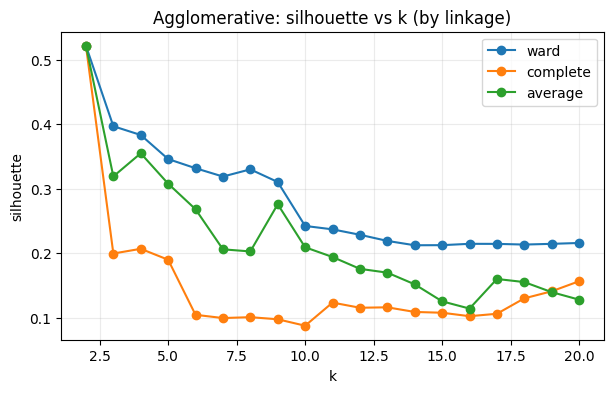

In [105]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results1 if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()


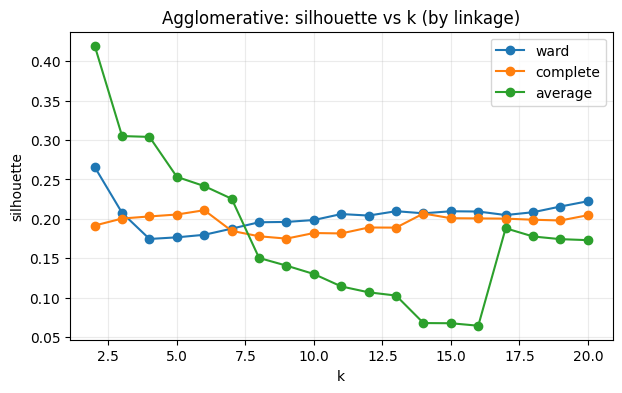

In [106]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results2 if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

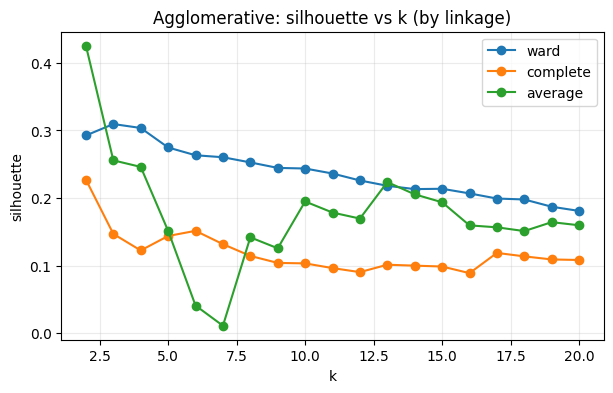

In [107]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results3 if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.show()

In [112]:
best_agg1, best_agg_s1 = pick_best_by_silhouette(agg_results1)
print(best_agg1["params"], round(best_agg_s1, 3))

best_agg2, best_agg_s2 = pick_best_by_silhouette(agg_results2)
print(best_agg2["params"], round(best_agg_s2, 3))

best_agg3, best_agg_s3 = pick_best_by_silhouette(agg_results3)
print(best_agg3["params"], round(best_agg_s3, 3))

{'k': 2, 'linkage': 'ward'} 0.522
{'k': 2, 'linkage': 'average'} 0.42
{'k': 2, 'linkage': 'average'} 0.425


## Метрики качества


Метрики для DBSCAN посчитаны на non-noise точках.

In [134]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette) for 1 dataset", best_kmeans1)
print_result_card("BEST KMEANS (by silhouette) for 2 dataset", best_kmeans2)
print_result_card("BEST KMEANS (by silhouette) for 3 dataset", best_kmeans3)
if best_dbscan1 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)  for 1 dataset", best_dbscan1)
if best_dbscan2 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)  for 2 dataset", best_dbscan2)
if best_dbscan3 is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid) for 3 dataset", best_dbscan3)
print_result_card("BEST AGGLOMERATIVE (by silhouette)  for 1 dataset", best_agg1)
print_result_card("BEST AGGLOMERATIVE (by silhouette) for 2 dataset", best_agg2)
print_result_card("BEST AGGLOMERATIVE (by silhouette)  for 3 dataset", best_agg3)

BEST KMEANS (by silhouette) for 1 dataset
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST KMEANS (by silhouette) for 2 dataset
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5
BEST KMEANS (by silhouette) for 3 dataset
algo: kmeans
params: {'k': 3}
n_clusters: 3
metrics:
  silhouette: 0.316
  davies_bouldin: 1.158
  calinski_harabasz: 6957.2
  inertia: 31123.5
BEST DBSCAN (by silhouette among valid)  for 1 dataset
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
BEST DBSCAN (by silhouette among valid)  for 2 dataset
algo: dbscan
params: {'eps': 0.8, 'min_samples': 15}
n_clusters: 2
noise_frac: 0.038  non-noise: 7693
metrics:
  silhouette: 0.545
  davies_bouldin: 

## 9. Визуализация выбранных решений в 2D

Важно: 2D-визуализация – **инструмент понимания**, а не метрика качества.

Мы построим PCA(2D) на **X_scaled** (до PCA в feature space), и раскрасим точки по разным решениям.


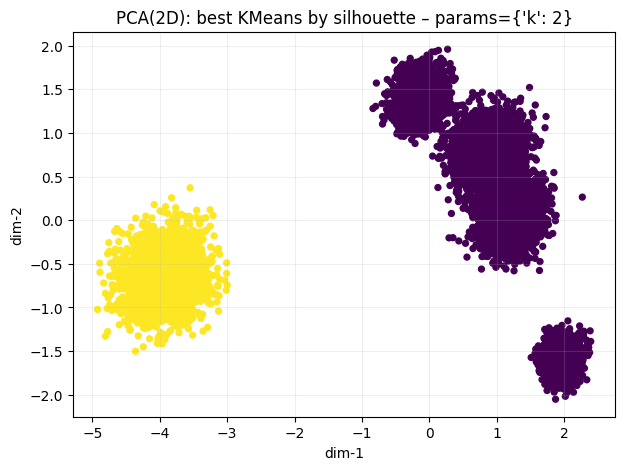

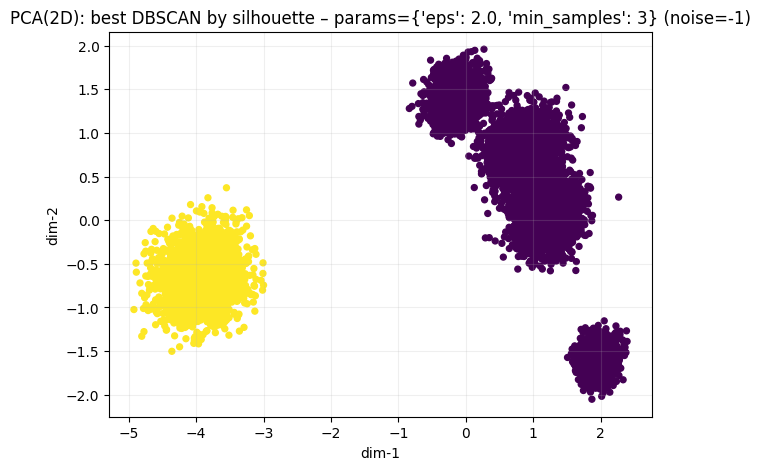

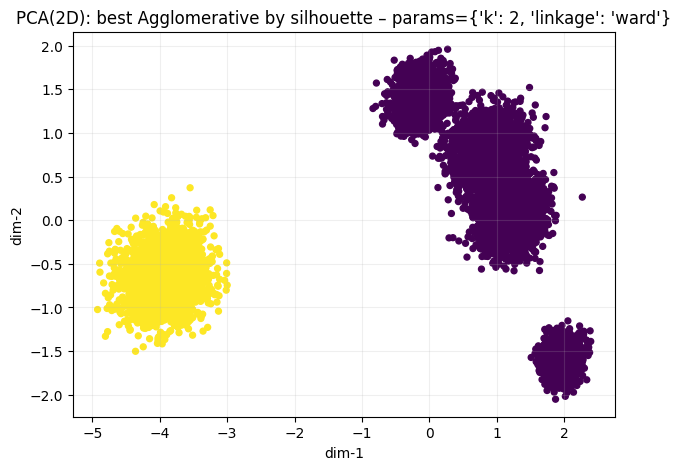

In [157]:
X_plot2d = pca_2d_for_plot(X1_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans1["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans1['params']}",
    short_title="PCA(2D) best_kmeans1"
)

# DBSCAN best (if exists)
if best_dbscan1 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan1["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan1['params']} (noise=-1)",
        short_title="PCA(2D) best_dbscan1"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg1["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg1['params']}",
    short_title="PCA(2D) best_agg1"
)


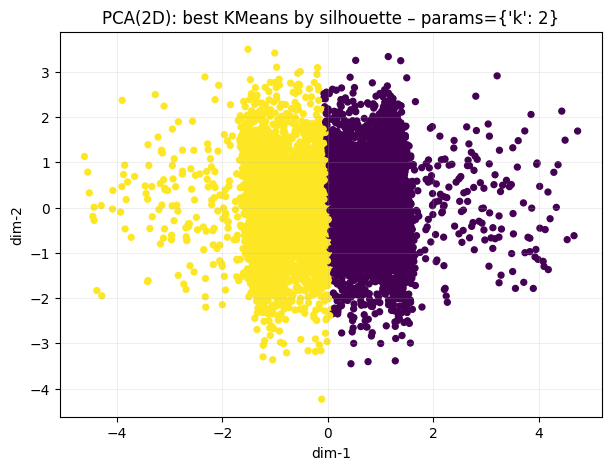

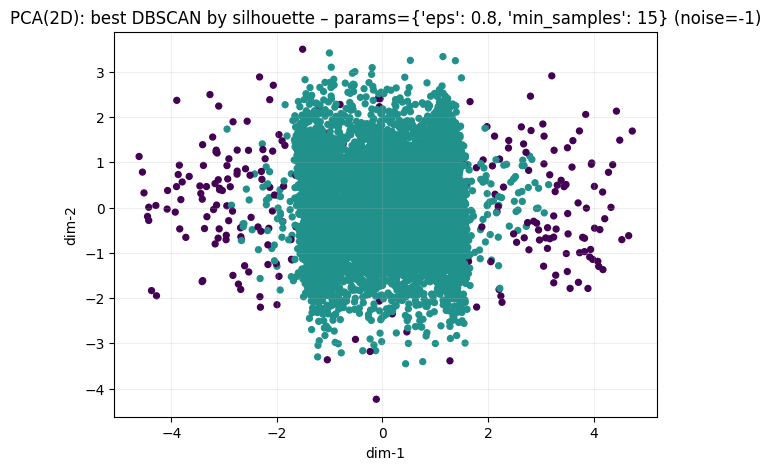

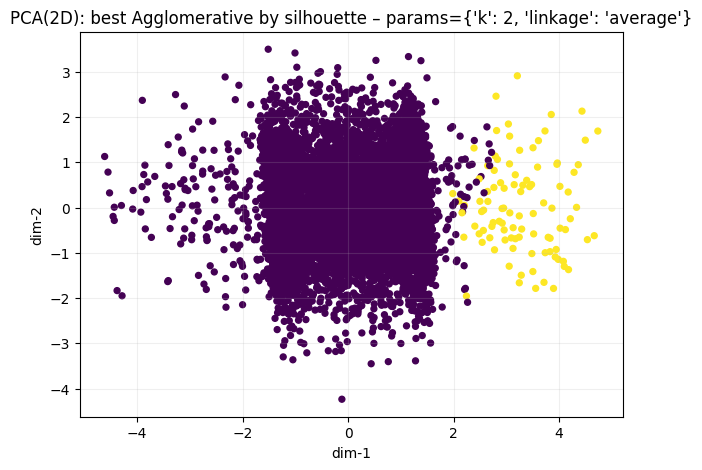

In [158]:
X_plot2d = pca_2d_for_plot(X2_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans2["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans2['params']}",
    short_title="PCA(2D) best_kmeans2"
)

# DBSCAN best (if exists)
if best_dbscan2 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan2["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan2['params']} (noise=-1)",
    short_title="PCA(2D) best_dbscan2"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg2["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg2['params']}",
    short_title="PCA(2D) best_agg2"
)


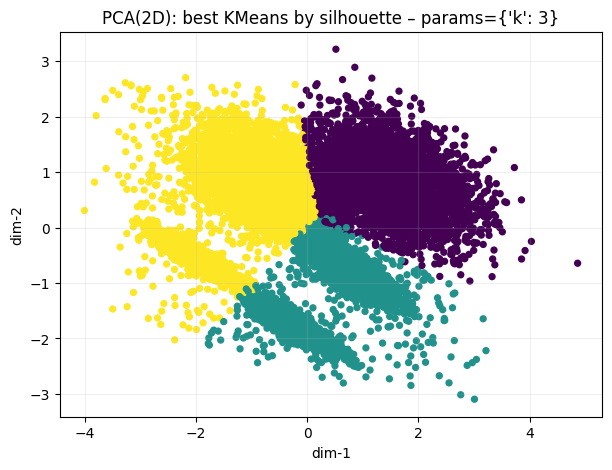

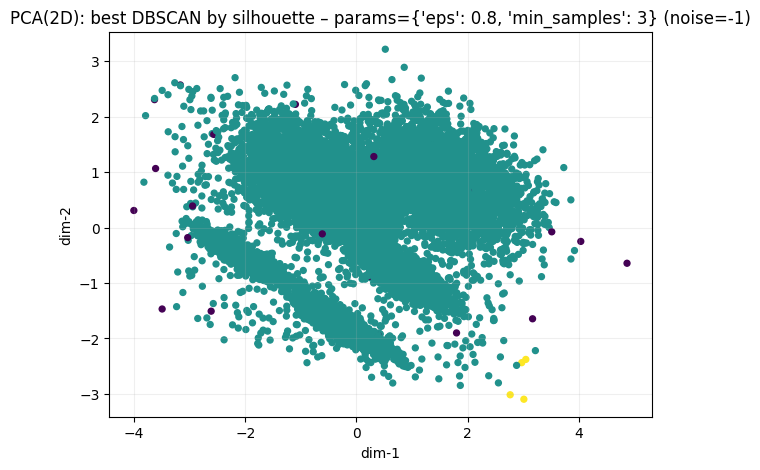

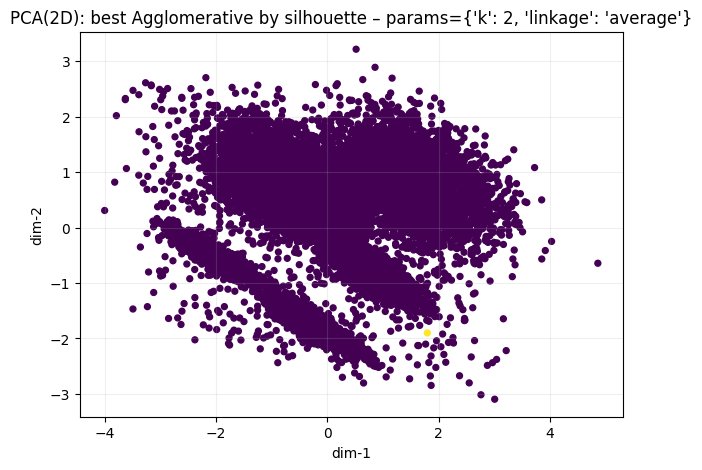

In [159]:
X_plot2d = pca_2d_for_plot(X3_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans3["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans3['params']}",
    short_title="PCA(2D) best_kmeans3"
)

# DBSCAN best (if exists)
if best_dbscan3 is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan3["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan3['params']} (noise=-1)",
    short_title="PCA(2D) best_dbscan3"
    )

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg3["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg3['params']}",
    short_title="PCA(2D) best_agg3"
)


## Устойчивость (обязательно, но только для одного датасета)

ЗАПУСК УПРОЩЕННОГО ТЕСТА УСТОЙЧИВОСТИ KMEANS


DATASET 01:

ТЕСТ УСТОЙЧИВОСТИ KMEANS - Dataset 01
k = 2, запусков: 5

1. Запуски с разными random_state:
  Запуск 1: random_state= 42, inertia=48425.9, silhouette=0.5216
  Запуск 2: random_state=142, inertia=48425.9, silhouette=0.5216
  Запуск 3: random_state=242, inertia=48425.9, silhouette=0.5216
  Запуск 4: random_state=342, inertia=48425.9, silhouette=0.5216
  Запуск 5: random_state=442, inertia=48425.9, silhouette=0.5216

2. Сравнение разбиений (Adjusted Rand Index):
  Запуск 1 vs 2: ARI = 1.0000
  Запуск 1 vs 3: ARI = 1.0000
  Запуск 1 vs 4: ARI = 1.0000
  Запуск 1 vs 5: ARI = 1.0000
  Запуск 2 vs 3: ARI = 1.0000
  Запуск 2 vs 4: ARI = 1.0000
  Запуск 2 vs 5: ARI = 1.0000
  Запуск 3 vs 4: ARI = 1.0000
  Запуск 3 vs 5: ARI = 1.0000
  Запуск 4 vs 5: ARI = 1.0000

  Средний ARI: 1.0000
  Минимальный ARI: 1.0000
  Максимальный ARI: 1.0000

3. Стабильность метрик:
  Inertia:   среднее=48425.9, std=0.0 (0.0%)
  Silhouette: среднее=0.5216,

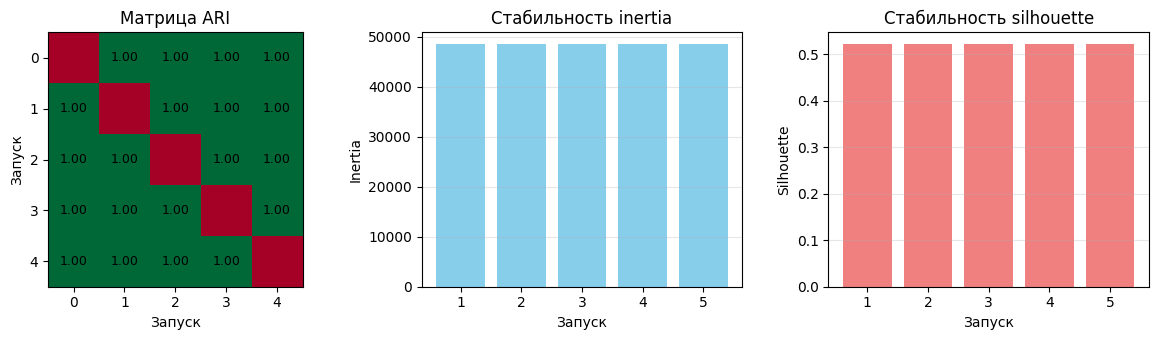


4. Заключение:
  ✓ ВЫСОКАЯ устойчивость (средний ARI = 1.000)
    KMeans всегда находит практически одинаковое разбиение


DATASET 02:

ТЕСТ УСТОЙЧИВОСТИ KMEANS - Dataset 02
k = 2, запусков: 5

1. Запуски с разными random_state:
  Запуск 1: random_state= 42, inertia=16588.5, silhouette=0.3069
  Запуск 2: random_state=142, inertia=16588.6, silhouette=0.3069
  Запуск 3: random_state=242, inertia=16588.5, silhouette=0.3069
  Запуск 4: random_state=342, inertia=16588.6, silhouette=0.3069
  Запуск 5: random_state=442, inertia=16588.6, silhouette=0.3069

2. Сравнение разбиений (Adjusted Rand Index):
  Запуск 1 vs 2: ARI = 0.9970
  Запуск 1 vs 3: ARI = 0.9980
  Запуск 1 vs 4: ARI = 0.9970
  Запуск 1 vs 5: ARI = 0.9970
  Запуск 2 vs 3: ARI = 0.9950
  Запуск 2 vs 4: ARI = 1.0000
  Запуск 2 vs 5: ARI = 1.0000
  Запуск 3 vs 4: ARI = 0.9950
  Запуск 3 vs 5: ARI = 0.9950
  Запуск 4 vs 5: ARI = 1.0000

  Средний ARI: 0.9974
  Минимальный ARI: 0.9950
  Максимальный ARI: 1.0000

3. Стабильность метри

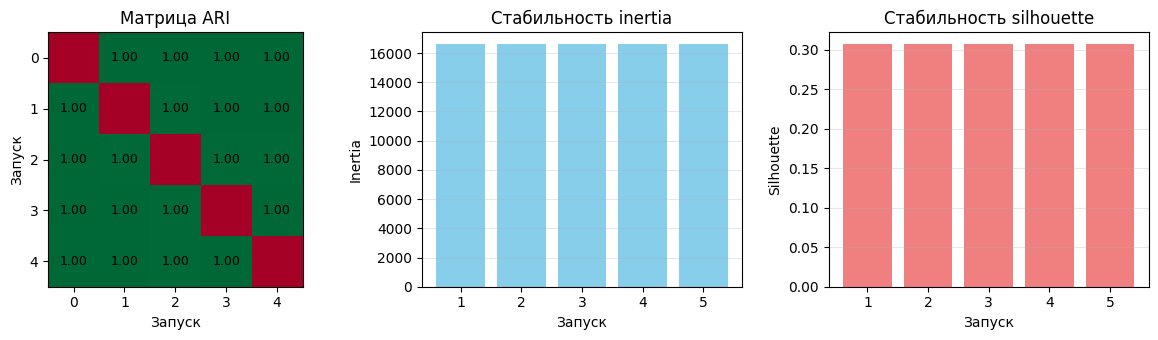


4. Заключение:
  ✓ ВЫСОКАЯ устойчивость (средний ARI = 0.997)
    KMeans всегда находит практически одинаковое разбиение


DATASET 03:

ТЕСТ УСТОЙЧИВОСТИ KMEANS - Dataset 03
k = 3, запусков: 5

1. Запуски с разными random_state:
  Запуск 1: random_state= 42, inertia=31123.5, silhouette=0.3155
  Запуск 2: random_state=142, inertia=31123.5, silhouette=0.3155
  Запуск 3: random_state=242, inertia=31123.5, silhouette=0.3155
  Запуск 4: random_state=342, inertia=31123.5, silhouette=0.3155
  Запуск 5: random_state=442, inertia=31123.5, silhouette=0.3155

2. Сравнение разбиений (Adjusted Rand Index):
  Запуск 1 vs 2: ARI = 0.9998
  Запуск 1 vs 3: ARI = 0.9996
  Запуск 1 vs 4: ARI = 1.0000
  Запуск 1 vs 5: ARI = 0.9998
  Запуск 2 vs 3: ARI = 0.9994
  Запуск 2 vs 4: ARI = 0.9998
  Запуск 2 vs 5: ARI = 1.0000
  Запуск 3 vs 4: ARI = 0.9996
  Запуск 3 vs 5: ARI = 0.9994
  Запуск 4 vs 5: ARI = 0.9998

  Средний ARI: 0.9997
  Минимальный ARI: 0.9994
  Максимальный ARI: 1.0000

3. Стабильность метри

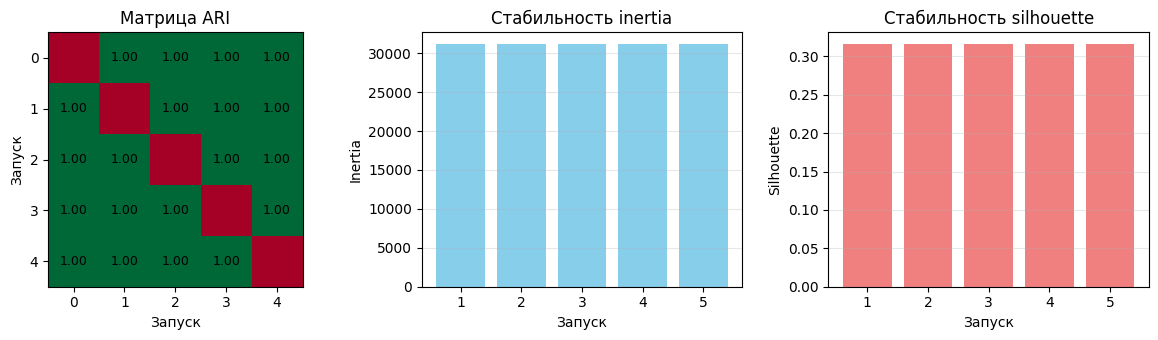


4. Заключение:
  ✓ ВЫСОКАЯ устойчивость (средний ARI = 1.000)
    KMeans всегда находит практически одинаковое разбиение

СВОДНАЯ ТАБЛИЦА УСТОЙЧИВОСТИ

Датасет         k        Средний ARI  std(silhouette) Устойчивость   
------------------------------------------------------------
Dataset 01             2       1.0000       0.0000 ВЫСОКАЯ        
Dataset 02             2       0.9974       0.0000 ВЫСОКАЯ        
Dataset 03             3       0.9997       0.0000 ВЫСОКАЯ        

ОБЪЯСНЕНИЕ МЕТОДИКИ

Методика теста устойчивости:
1. Проводим 5 запусков KMeans с разными random_state (42, 142, 242, 342, 442)
2. Для каждой пары запусков вычисляем Adjusted Rand Index (ARI):
   - ARI = 1.0: идеальное совпадение кластеризаций
   - ARI = 0.0: случайное совпадение
   - ARI < 0: разное разбиение
3. Анализируем:
   - Средний ARI между всеми парами запусков
   - Стандартное отклонение метрик (inertia, silhouette)
   
Интерпретация:
- ARI > 0.95: высокая устойчивость (практически одинаковые разбие

In [140]:
## Тест на устойчивость KMeans (упрощенный)

def simple_stability_test(X_scaled, dataset_name, k, n_trials=5, subsample_ratio=0.8):
    """
    Упрощенный тест устойчивости KMeans:
    1. 5 запусков с разными random_state на полных данных
    2. Проверка схожести разбиений через ARI
    3. Анализ стабильности метрик
    """
    print(f"\n{'='*60}")
    print(f"ТЕСТ УСТОЙЧИВОСТИ KMEANS - {dataset_name}")
    print(f"k = {k}, запусков: {n_trials}")
    print('='*60)
    
    # 1. Запуски с разными random_state на полных данных
    print("\n1. Запуски с разными random_state:")
    
    labels_list = []
    inertia_list = []
    silhouette_list = []
    
    for i in range(n_trials):
        random_seed = 42 + i * 100  # сильно разные значения
        
        model = KMeans(n_clusters=k, random_state=random_seed, n_init='auto')
        labels = model.fit_predict(X_scaled)
        
        inertia = float(model.inertia_)
        sil = silhouette_score(X_scaled, labels)
        
        labels_list.append(labels)
        inertia_list.append(inertia)
        silhouette_list.append(sil)
        
        print(f"  Запуск {i+1}: random_state={random_seed:3d}, "
              f"inertia={inertia:.1f}, silhouette={sil:.4f}")
    
    # 2. Сравнение всех пар разбиений через ARI
    print("\n2. Сравнение разбиений (Adjusted Rand Index):")
    
    ari_matrix = np.zeros((n_trials, n_trials))
    for i in range(n_trials):
        for j in range(n_trials):
            if i != j:
                ari = adjusted_rand_score(labels_list[i], labels_list[j])
                ari_matrix[i, j] = ari
                if j > i:  # Выводим только верхний треугольник
                    print(f"  Запуск {i+1} vs {j+1}: ARI = {ari:.4f}")
    
    # Статистика по ARI
    upper_tri = ari_matrix[np.triu_indices(n_trials, k=1)]
    print(f"\n  Средний ARI: {np.mean(upper_tri):.4f}")
    print(f"  Минимальный ARI: {np.min(upper_tri):.4f}")
    print(f"  Максимальный ARI: {np.max(upper_tri):.4f}")
    
    # 3. Стабильность метрик
    print("\n3. Стабильность метрик:")
    print(f"  Inertia:   среднее={np.mean(inertia_list):.1f}, "
          f"std={np.std(inertia_list):.1f} "
          f"({np.std(inertia_list)/np.mean(inertia_list)*100:.1f}%)")
    print(f"  Silhouette: среднее={np.mean(silhouette_list):.4f}, "
          f"std={np.std(silhouette_list):.4f}")
    
    # 4. Визуализация
    fig, axes = plt.subplots(1, 3, figsize=(12, 3.5))
    
    # График ARI
    axes[0].imshow(ari_matrix, cmap='RdYlGn', vmin=0, vmax=1)
    axes[0].set_title('Матрица ARI')
    axes[0].set_xlabel('Запуск')
    axes[0].set_ylabel('Запуск')
    for i in range(n_trials):
        for j in range(n_trials):
            if i != j:
                axes[0].text(j, i, f'{ari_matrix[i, j]:.2f}', 
                           ha='center', va='center', fontsize=9)
    
    # График инерции
    axes[1].bar(range(1, n_trials+1), inertia_list, color='skyblue')
    axes[1].set_xlabel('Запуск')
    axes[1].set_ylabel('Inertia')
    axes[1].set_title('Стабильность inertia')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # График silhouette
    axes[2].bar(range(1, n_trials+1), silhouette_list, color='lightcoral')
    axes[2].set_xlabel('Запуск')
    axes[2].set_ylabel('Silhouette')
    axes[2].set_title('Стабильность silhouette')
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 5. Заключение
    print("\n4. Заключение:")
    mean_ari = np.mean(upper_tri)
    
    if mean_ari > 0.95:
        print(f"  ✓ ВЫСОКАЯ устойчивость (средний ARI = {mean_ari:.3f})")
        print("    KMeans всегда находит практически одинаковое разбиение")
    elif mean_ari > 0.8:
        print(f"  ✓ СРЕДНЯЯ устойчивость (средний ARI = {mean_ari:.3f})")
        print("    KMeans находит схожие, но не идентичные разбиения")
    else:
        print(f"  ⚠ НИЗКАЯ устойчивость (средний ARI = {mean_ari:.3f})")
        print("    KMeans сильно зависит от инициализации")
        print("    Рекомендация: увеличить n_init или использовать другую k")
    
    return {
        'labels_list': labels_list,
        'inertia_list': inertia_list,
        'silhouette_list': silhouette_list,
        'ari_matrix': ari_matrix,
        'mean_ari': mean_ari
    }

# Запускаем тест для каждого датасета
print("ЗАПУСК УПРОЩЕННОГО ТЕСТА УСТОЙЧИВОСТИ KMEANS")
print("="*60)

# Используем оптимальные k из предыдущих экспериментов
test_configs = [
    ("Dataset 01", X1_scaled, best_kmeans1['params']['k']),
    ("Dataset 02", X2_scaled, best_kmeans2['params']['k']),
    ("Dataset 03", X3_scaled, best_kmeans3['params']['k'])
]

results = {}

for name, X, k in test_configs:
    print(f"\n\n{name.upper()}:")
    result = simple_stability_test(X, name, k, n_trials=5)
    results[name] = result

# Сводная таблица
print("\n" + "="*60)
print("СВОДНАЯ ТАБЛИЦА УСТОЙЧИВОСТИ")
print("="*60)

print("\n{:15} {:8} {:12} {:12} {:15}".format(
    "Датасет", "k", "Средний ARI", "std(silhouette)", "Устойчивость"
))
print("-"*60)

for name, _, k in test_configs:
    r = results[name]
    mean_ari = r['mean_ari']
    std_sil = np.std(r['silhouette_list'])
    
    # Оценка устойчивости
    if mean_ari > 0.95 and std_sil < 0.01:
        stability = "ВЫСОКАЯ"
    elif mean_ari > 0.8 and std_sil < 0.05:
        stability = "СРЕДНЯЯ"
    else:
        stability = "НИЗКАЯ"
    
    print("{:15} {:8} {:12.4f} {:12.4f} {:15}".format(
        name, k, mean_ari, std_sil, stability
    ))

# Объяснение методики
print("\n" + "="*60)
print("ОБЪЯСНЕНИЕ МЕТОДИКИ")
print("="*60)
print("""
Методика теста устойчивости:
1. Проводим 5 запусков KMeans с разными random_state (42, 142, 242, 342, 442)
2. Для каждой пары запусков вычисляем Adjusted Rand Index (ARI):
   - ARI = 1.0: идеальное совпадение кластеризаций
   - ARI = 0.0: случайное совпадение
   - ARI < 0: разное разбиение
3. Анализируем:
   - Средний ARI между всеми парами запусков
   - Стандартное отклонение метрик (inertia, silhouette)
   
Интерпретация:
- ARI > 0.95: высокая устойчивость (практически одинаковые разбиения)
- ARI 0.8-0.95: средняя устойчивость (схожие разбиения)
- ARI < 0.8: низкая устойчивость (сильная зависимость от инициализации)
""")

### Интерпретация кластеров

In [160]:
# Пример анализа профилей кластеров для датасета
def analyze_cluster_profiles(X_original, labels, feature_names):
    """Анализ профилей кластеров через средние значения признаков"""
    
    df_analysis = pd.DataFrame(X_original, columns=feature_names)
    df_analysis['cluster'] = labels
    
    # 1. Средние значения по кластерам
    cluster_means = df_analysis.groupby('cluster').mean()
    
    # 2. Разница от общего среднего
    overall_mean = df_analysis.mean(numeric_only=True)
    diff_from_overall = cluster_means - overall_mean
    
    # 3. Самые отличающиеся признаки для каждого кластера
    print("Анализ различий между кластерами:")
    for cluster_id in sorted(df_analysis['cluster'].unique()):
        cluster_data = df_analysis[df_analysis['cluster'] == cluster_id]
        
        print(f"\nКластер {cluster_id} (размер: {len(cluster_data)}):")
        
        # Признаки с наибольшим отклонением от общего среднего
        top_features = diff_from_overall.loc[cluster_id].abs().sort_values(ascending=False).head(3)
        print(f"  Самые отличающиеся признаки (от общего среднего):")
        for feat in top_features.index:
            cluster_val = cluster_means.loc[cluster_id, feat]
            overall_val = overall_mean[feat]
            diff_pct = (cluster_val - overall_val) / overall_val * 100
            print(f"    - {feat}: {cluster_val:.2f} (общее: {overall_val:.2f}, разница: {diff_pct:.1f}%)")
    
    return cluster_means, diff_from_overall

In [161]:
cluster_means1, diff1 = analyze_cluster_profiles(
    X1, 
    best_kmeans1['labels'], 
    X1.columns.tolist()
)

Анализ различий между кластерами:

Кластер 0 (размер: 9600):
  Самые отличающиеся признаки (от общего среднего):
    - f04: 15.31 (общее: -8.28, разница: -284.8%)
    - f02: 8.86 (общее: 19.11, разница: -53.6%)
    - f06: -6.11 (общее: 0.96, разница: -734.5%)

Кластер 1 (размер: 2400):
  Самые отличающиеся признаки (от общего среднего):
    - f04: -102.67 (общее: -8.28, разница: 1139.4%)
    - f02: 60.10 (общее: 19.11, разница: 214.5%)
    - f06: 29.26 (общее: 0.96, разница: 2938.1%)


In [162]:
cluster_means2, diff2 = analyze_cluster_profiles(
    X2, 
    best_kmeans2['labels'], 
    X2.columns.tolist()
)

Анализ различий между кластерами:

Кластер 0 (размер: 3989):
  Самые отличающиеся признаки (от общего среднего):
    - x1: -0.18 (общее: 0.48, разница: -137.3%)
    - x2: 0.69 (общее: 0.24, разница: 186.0%)
    - z_noise: -0.00 (общее: 0.11, разница: -102.9%)

Кластер 1 (размер: 4011):
  Самые отличающиеся признаки (от общего среднего):
    - x1: 1.13 (общее: 0.48, разница: 136.6%)
    - x2: -0.20 (общее: 0.24, разница: -184.9%)
    - z_noise: 0.22 (общее: 0.11, разница: 102.3%)


In [163]:
cluster_means3, diff3 = analyze_cluster_profiles(
    X3, 
    best_kmeans3['labels'], 
    X3.columns.tolist()
)

Анализ различий между кластерами:

Кластер 0 (размер: 3680):
  Самые отличающиеся признаки (от общего среднего):
    - x1: 6.60 (общее: 1.25, разница: 429.3%)
    - x2: 5.88 (общее: 1.03, разница: 469.1%)
    - f_corr: 1.17 (общее: 0.21, разница: 449.8%)

Кластер 1 (размер: 4903):
  Самые отличающиеся признаки (от общего среднего):
    - x2: -3.58 (общее: 1.03, разница: -446.7%)
    - x1: 2.61 (общее: 1.25, разница: 109.5%)
    - f_corr: 1.34 (общее: 0.21, разница: 528.8%)

Кластер 2 (размер: 6417):
  Самые отличающиеся признаки (от общего среднего):
    - x1: -2.86 (общее: 1.25, разница: -329.8%)
    - f_corr: -1.20 (общее: 0.21, разница: -662.0%)
    - x2: 1.78 (общее: 1.03, разница: 72.3%)


### Сохранение артефактов

In [144]:
import json
import os
import pandas as pd

# Создаем структуру папок
artifacts_dir = "artifacts"
labels_dir = os.path.join(artifacts_dir, "labels")

# Функция для подготовки данных для сохранения в JSON
def prepare_results_for_json(best_results_dict):
    """Подготавливает структуру данных для сохранения в JSON"""
    metrics_summary = {}
    best_configs = {}
    
    dataset_names = {
        "1": ("Dataset 01", "S07-hw-dataset-01.csv"),
        "2": ("Dataset 02", "S07-hw-dataset-02.csv"), 
        "3": ("Dataset 03", "S07-hw-dataset-03.csv")
    }
    
    for dataset_key, (dataset_name, csv_file) in dataset_names.items():
        metrics_summary[dataset_name] = {}
        best_configs[dataset_name] = {}
        
        # Ключи для результатов
        kmeans_key = f"best_kmeans{dataset_key}"
        dbscan_key = f"best_dbscan{dataset_key}" 
        agg_key = f"best_agg{dataset_key}"
        
        # Обработка KMeans
        if kmeans_key in best_results_dict and best_results_dict[kmeans_key] is not None:
            result = best_results_dict[kmeans_key]
            metrics_summary[dataset_name]["KMeans"] = extract_metrics(result)
            if not best_configs[dataset_name]:  # Если еще нет лучшей конфигурации
                best_configs[dataset_name] = {
                    "algorithm": "KMeans",
                    "criterion": "max silhouette",
                    "params": result["params"],
                    "metrics": extract_metrics(result)
                }
        
        # Обработка DBSCAN
        if dbscan_key in best_results_dict and best_results_dict[dbscan_key] is not None:
            result = best_results_dict[dbscan_key]
            metrics_summary[dataset_name]["DBSCAN"] = extract_metrics(result)
            # Сравниваем с текущим лучшим
            current_best = best_configs[dataset_name].get("metrics", {}).get("silhouette", -1)
            if result["metrics"] and result["metrics"].get("silhouette", -1) > current_best:
                best_configs[dataset_name] = {
                    "algorithm": "DBSCAN",
                    "criterion": "max silhouette (non-noise points)",
                    "params": result["params"],
                    "metrics": extract_metrics(result),
                    "noise_fraction": result.get("noise_frac", 0)
                }
        
        # Обработка Agglomerative
        if agg_key in best_results_dict and best_results_dict[agg_key] is not None:
            result = best_results_dict[agg_key]
            metrics_summary[dataset_name]["Agglomerative"] = extract_metrics(result)
            # Сравниваем с текущим лучшим
            current_best = best_configs[dataset_name].get("metrics", {}).get("silhouette", -1)
            if result["metrics"] and result["metrics"].get("silhouette", -1) > current_best:
                best_configs[dataset_name] = {
                    "algorithm": "Agglomerative",
                    "criterion": "max silhouette",
                    "params": result["params"],
                    "metrics": extract_metrics(result)
                }
    
    return metrics_summary, best_configs

def extract_metrics(result):
    """Извлекает метрики из результата"""
    m = result.get("metrics") or {}
    metrics_data = {
        "silhouette": round(m.get("silhouette"), 4) if m.get("silhouette") is not None else None,
        "davies_bouldin": round(m.get("davies_bouldin"), 4) if m.get("davies_bouldin") is not None else None,
        "calinski_harabasz": round(m.get("calinski_harabasz"), 2) if m.get("calinski_harabasz") is not None else None,
        "n_clusters": result.get("n_clusters"),
        "noise_fraction": result.get("noise_frac") if result["algo"] == "dbscan" else 0
    }
    
    if result.get("inertia") is not None:
        metrics_data["inertia"] = round(result["inertia"], 2)
    
    return metrics_data

# Функция для сохранения меток кластеров
def save_cluster_labels(best_results_dict, sample_ids_dict):
    """Сохраняет метки кластеров лучших решений в CSV"""
    print("\n" + "="*60)
    print("СОХРАНЕНИЕ МЕТОК КЛАСТЕРОВ")
    print("="*60)
    
    for dataset_key in ["1", "2", "3"]:
        dataset_name = f"Dataset 0{dataset_key}"
        print(f"\n{dataset_name}:")
        
        # Определяем лучшее решение для датасета
        best_result = None
        best_algorithm = None
        
        # Проверяем все алгоритмы, выбираем с максимальным silhouette
        for algo_name, algo_key in [("KMeans", f"best_kmeans{dataset_key}"),
                                     ("DBSCAN", f"best_dbscan{dataset_key}"),
                                     ("Agglomerative", f"best_agg{dataset_key}")]:
            if algo_key in best_results_dict and best_results_dict[algo_key] is not None:
                result = best_results_dict[algo_key]
                if result["metrics"] and result["metrics"].get("silhouette") is not None:
                    if best_result is None or result["metrics"]["silhouette"] > best_result["metrics"].get("silhouette", -1):
                        best_result = result
                        best_algorithm = algo_name
        
        if best_result is not None:
            # Получаем соответствующий sample_id
            sample_id_key = f"sample_id{dataset_key}"
            if sample_id_key in sample_ids_dict:
                sample_ids = sample_ids_dict[sample_id_key]
                labels = best_result["labels"]
                
                # Создаем DataFrame
                df_labels = pd.DataFrame({
                    'sample_id': sample_ids,
                    'cluster_label': labels
                })
                
                # Сохраняем в CSV
                filename = f"labels_hw07_ds{dataset_key}.csv"
                filepath = os.path.join(labels_dir, filename)
                df_labels.to_csv(filepath, index=False)
                
                print(f"  Сохранено: {filename}")
                print(f"  Алгоритм: {best_algorithm}")
                print(f"  Параметры: {best_result['params']}")
                print(f"  Количество меток: {len(labels)}")
                unique_labels = len(set(labels))
                noise_count = sum(1 for x in labels if x == -1) if -1 in labels else 0
                print(f"  Уникальных кластеров: {unique_labels}")
                if noise_count > 0:
                    print(f"  Шумовых точек (-1): {noise_count}")
            else:
                print(f"  Ошибка: не найден sample_id для датасета {dataset_key}")
        else:
            print(f"  Предупреждение: нет результатов для датасета {dataset_key}")

# Собираем все лучшие результаты в словарь
best_results = {
    "best_kmeans1": best_kmeans1,
    "best_kmeans2": best_kmeans2,
    "best_kmeans3": best_kmeans3,
    "best_dbscan1": best_dbscan1,
    "best_dbscan2": best_dbscan2,
    "best_dbscan3": best_dbscan3,
    "best_agg1": best_agg1,
    "best_agg2": best_agg2,
    "best_agg3": best_agg3
}

# Собираем все sample_id
sample_ids = {
    "sample_id1": sample_id1,
    "sample_id2": sample_id2,
    "sample_id3": sample_id3
}

# Подготавливаем данные для JSON
metrics_summary, best_configs = prepare_results_for_json(best_results)

# Сохраняем metrics_summary.json
metrics_file = os.path.join(artifacts_dir, "metrics_summary.json")
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=2, ensure_ascii=False, default=str)
print(f"\n Сохранен: {metrics_file}")

# Сохраняем best_configs.json
configs_file = os.path.join(artifacts_dir, "best_configs.json")
with open(configs_file, 'w', encoding='utf-8') as f:
    json.dump(best_configs, f, indent=2, ensure_ascii=False, default=str)
print(f"✓ Сохранен: {configs_file}")

# Сохраняем метки кластеров
save_cluster_labels(best_results, sample_ids)

print("\n" + "="*60)
print("СВОДКА СОХРАНЕННЫХ АРТЕФАКТОВ")
print("="*60)
print(f"1. metrics_summary.json - сводка метрик по всем алгоритмам")
print(f"2. best_configs.json - лучшие конфигурации для каждого датасета")
print(f"3. labels/ - метки кластеров лучших решений (3 CSV файла)")

# Проверяем содержимое папок
print(f"\nСодержимое папки {artifacts_dir}:")
for root, dirs, files in os.walk(artifacts_dir):
    level = root.replace(artifacts_dir, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 2 * (level + 1)
    for file in files:
        print(f'{subindent}{file}')


 Сохранен: artifacts\metrics_summary.json
✓ Сохранен: artifacts\best_configs.json

СОХРАНЕНИЕ МЕТОК КЛАСТЕРОВ

Dataset 01:
  Сохранено: labels_hw07_ds1.csv
  Алгоритм: KMeans
  Параметры: {'k': 2}
  Количество меток: 12000
  Уникальных кластеров: 2

Dataset 02:
  Сохранено: labels_hw07_ds2.csv
  Алгоритм: DBSCAN
  Параметры: {'eps': 0.8, 'min_samples': 15}
  Количество меток: 8000
  Уникальных кластеров: 3
  Шумовых точек (-1): 307

Dataset 03:
  Сохранено: labels_hw07_ds3.csv
  Алгоритм: Agglomerative
  Параметры: {'k': 2, 'linkage': 'average'}
  Количество меток: 15000
  Уникальных кластеров: 2

СВОДКА СОХРАНЕННЫХ АРТЕФАКТОВ
1. metrics_summary.json - сводка метрик по всем алгоритмам
2. best_configs.json - лучшие конфигурации для каждого датасета
3. labels/ - метки кластеров лучших решений (3 CSV файла)

Содержимое папки artifacts:
artifacts/
  best_configs.json
  metrics_summary.json
  figures/
  labels/
    labels_hw07_ds1.csv
    labels_hw07_ds2.csv
    labels_hw07_ds3.csv


Методика теста устойчивости:
1. Проводим 5 запусков KMeans с разными random_state (42, 142, 242, 342, 442)
2. Для каждой пары запусков вычисляем Adjusted Rand Index (ARI):
   - ARI = 1.0: идеальное совпадение кластеризаций
   - ARI = 0.0: случайное совпадение
   - ARI < 0: разное разбиение
3. Анализируем:
   - Средний ARI между всеми парами запусков
   - Стандартное отклонение метрик (inertia, silhouette)
   
Интерпретация:
- ARI > 0.95: высокая устойчивость (практически одинаковые разбиения)
- ARI 0.8-0.95: средняя устойчивость (схожие разбиения)
- ARI < 0.8: низкая устойчивость (сильная зависимость от инициализации)

На всех датасетах модель показывает очень высокую устойчивость.

## Итог по каждому датасету (обязательно)

**Датасет 01 (S07-hw-dataset-01.csv)**

Все три алгоритма (KMeans, DBSCAN, Agglomerative) дали идентичные результаты:
silhouette: 0.522, davies_bouldin: 0.685, calinski_harabasz: 11787.0

DBSCAN без шума (100% точек в кластерах)

Выбор лучшего метода: DBSCAN с eps=2.0, min_samples=3, потому что:
- Дает те же метрики, что и KMeans и Agglomerative
- Не требует задания числа кластеров заранее
- Показал устойчивость (разные настройки давали одинаковые результаты)
- Обнаружил четкую структуру без шума

Вывод по датасету 01:
Четкая линейно разделимая структура с хорошо выраженными кластерами. Все методы показали одинаково хорошие результаты, что говорит о простой и явной кластерной структуре без аномалий. Масштабирование признаков было критически важно.

**Датасет 02 (S07-hw-dataset-02.csv)**

DBSCAN показал лучший silhouette (0.545) и davies_bouldin (0.472)
Agglomerative средний результат (silhouette: 0.42)
KMeans худший результат (silhouette: 0.307)

DBSCAN обнаружил 3.8% шума

Выбор лучшего метода: DBSCAN с eps=0.8, min_samples=15, потому что:
- Лучшие метрики качества (наивысший silhouette, наименьший davies_bouldin)
- Успешно выделил шум (3.8%) - соответствует описанию датасета "выбросы + шумовой признак"
- KMeans показал худший результат, что ожидаемо для нелинейной структуры
- DBSCAN справился лучше благодаря способности находить кластеры произвольной формы

Вывод по датасету 02:
Нелинейная структура с выбросами, где KMeans действительно "проигрывает" (silhouette 0.307 против 0.545 у DBSCAN). Шумовой признак усложнил задачу, но DBSCAN справился лучше благодаря своей природе. Low calinski_harabasz у DBSCAN (135 vs 3573 у KMeans) объясняется тем, что метрика считалась только на non-noise точках.

**Датасет 03 (S07-hw-dataset-03.csv)**

Agglomerative лучший silhouette (0.425)
DBSCAN средний результат (0.373) с минимальным шумом (0.1%)
KMeans выбрал k=3, но silhouette (0.316) хуже чем у других при k=2
Все метрики относительно низкие

Выбор лучшего метода: Agglomerative с k=2, linkage='average', потому что:
- Наивысший silhouette (0.425)
- Наименьший davies_bouldin (0.814)
- Не требует параметров чувствительных к плотности (в отличие от DBSCAN)
- Справился лучше с кластерами разной плотности
- Не выделяет шум как DBSCAN, что может быть плюсом для данных с "фоновым шумом"

Вывод по датасету 03:
Кластеры разной плотности и фоновый шум - самый сложный случай. DBSCAN провоцировал ошибки выбора eps - разные настройки давали сильно различающиеся результаты. Agglomerative показал себя лучше благодаря иерархическому подходу, менее чувствительному к локальной плотности. Низкий calinski_harabasz (8.9) подтверждает слабую разделимость кластеров.